In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install tensorflow_hub

In [ ]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
!kaggle datasets download -d tharakan684/urecamain

 99% 96.0M/96.8M [00:05<00:00, 23.0MB/s]
100% 96.8M/96.8M [00:05<00:00, 18.0MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/urecamain.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/Train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(160,160)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/Vali',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(160,160)
)

test_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/Test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(160,160)
)

Found 6003 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00


In [ ]:
import wandb
wandb.login()

wandb: Currently logged in as: d-soumyadeepofficial. Use `wandb login --relogin` to force relogin


True

In [ ]:
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

In [ ]:
import random
wandb.init(
        project="fire-detection",
        # (optional) set entity to specify your username or team name
        # entity="my_team",
        config={
            "layer_1": 256,
            "activation_1": "relu",
            "dropout": 0.2,
            "optimizer": "adam",
            "metric": "accuracy",
            "epoch": 10,
            "batch_size": 32,
        },
    )
config = wandb.config

In [ ]:
IMAGE_SHAPE=(160,160)
classification_model = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-160-feature-vector/versions/2" ,input_shape=IMAGE_SHAPE+(3,),trainable=True,arguments=dict(batch_norm_momentum=0.997))
])

In [ ]:
num_of_classes = 2

model = tf.keras.Sequential([
  classification_model,
  tf.keras.layers.Dense(config.layer_1, activation=config.activation_1),
  tf.keras.layers.Dropout(config.dropout),
  tf.keras.layers.Dense(config.layer_1, activation=config.activation_1),
  tf.keras.layers.Dropout(config.dropout),
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 1280)              410208    
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 804450 (3.07 MB)
Trainable params: 79037

In [ ]:
wandb_callbacks = [
      WandbMetricsLogger(),

    ]

In [ ]:
model.compile(
  optimizer=config.optimizer,
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[config.metric])

history=model.fit(train_ds,epochs=config.epoch,validation_data=validation_ds,callbacks=wandb_callbacks)
wandb.finish()

Epoch 1/10
188/188 [==============================] - 47s 82ms/step - loss: 0.1903 - accuracy: 0.9400 - val_loss: 4.9199 - val_accuracy: 0.6250
Epoch 2/10
188/188 [==============================] - 13s 67ms/step - loss: 0.1088 - accuracy: 0.9760 - val_loss: 1.6740 - val_accuracy: 0.7660
Epoch 3/10
188/188 [==============================] - 14s 75ms/step - loss: 0.1079 - accuracy: 0.9787 - val_loss: 0.5497 - val_accuracy: 0.9065
Epoch 4/10
188/188 [==============================] - 14s 74ms/step - loss: 0.1052 - accuracy: 0.9810 - val_loss: 0.3026 - val_accuracy: 0.9600
Epoch 5/10
188/188 [==============================] - 14s 76ms/step - loss: 0.0856 - accuracy: 0.9845 - val_loss: 0.1382 - val_accuracy: 0.9760
Epoch 6/10
188/188 [==============================] - 13s 69ms/step - loss: 0.0860 - accuracy: 0.9837 - val_loss: 0.4408 - val_accuracy: 0.9330
Epoch 7/10
188/188 [==============================] - 13s 68ms/step - loss: 0.0837 - accuracy: 0.9873 - val_loss: 0.2795 - val_accuracy:

epoch/accuracy,▁▆▆▇▇▇███▇
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▃▁▁▁▁▁▂
epoch/val_accuracy,▁▄▇██▇▇█▇▇
epoch/val_loss,█▃▂▁▁▁▁▁▁▁
epoch/accuracy,0.98567
epoch/epoch,9
epoch/learning_rate,0.001
epoch/loss,0.08686
epoch/val_accuracy,0.941


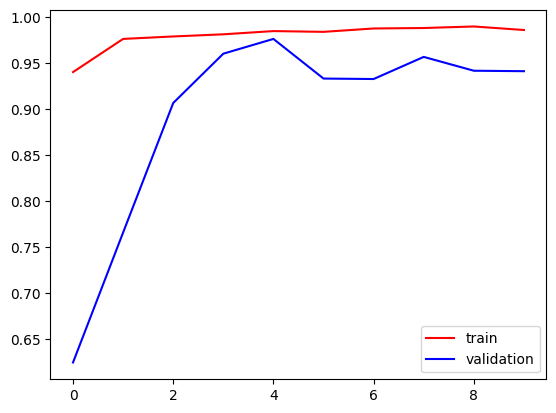

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_ds)

63/63 [==============================] - 2s 22ms/step - loss: 0.4241 - accuracy: 0.9405


[0.4241437315940857, 0.940500020980835]

1/1 [==============================] - 1s 1s/step


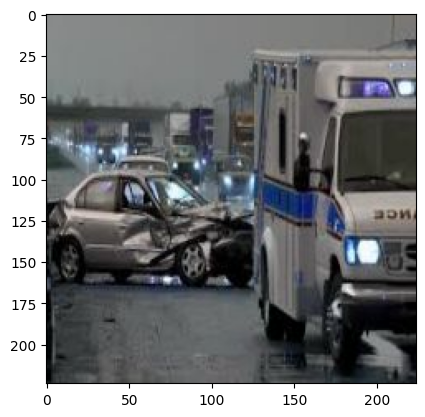

In [ ]:
import cv2
test_img = cv2.imread('/content/Test/Non-Fire/crash116.jpg')
plt.imshow(test_img)
test_img = cv2.resize(test_img,(IMAGE_SHAPE))
test_input = test_img.reshape((1,160,160,3))
result=model.predict(test_input)


In [ ]:

predicted_label_index = np.argmax(result)
predicted_label_index

1

1/1 [==============================] - 0s 20ms/step


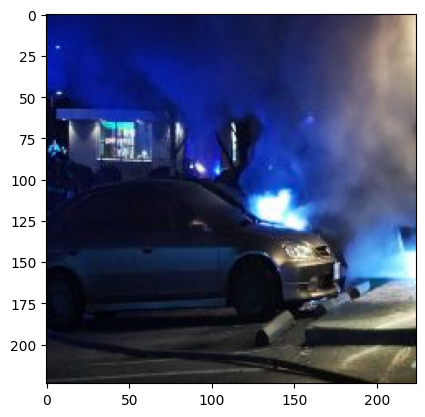

In [ ]:
import cv2
test_img = cv2.imread('/content/Vali/Fire/nightroad8.jpg')
plt.imshow(test_img)
test_img = cv2.resize(test_img,(IMAGE_SHAPE))
test_input = test_img.reshape((1,160,160,3))
result=model.predict(test_input)

In [ ]:

predicted_label_index = np.argmax(result)
predicted_label_index

0

In [ ]:
!pip install tensorflow_docs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.6/183.6 kB 3.9 MB/s eta 0:00:00


In [ ]:
!pip install remotezip

  Preparing metadata (setup.py) ... done
  Created wheel for remotezip: filename=remotezip-0.12.2-py3-none-any.whl size=7890 sha256=923c37f38d6a83c33a90022af75e1d70fbd40c7886f4a433418b83e50b862ab2
  Stored in directory: /root/.cache/pip/wheels/f2/71/f9/c650cc34039d772da8b040ed447b6b5f5de9abc38d88073fa1
Successfully built remotezip


In [ ]:
model.save('fire_detect_v1.keras')